# Weighted Dataset Model

- Train: AnyAgree_train
- Test: 75Agree_test

# TODO

- cv

In [37]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
from collections import Counter
from transformers import get_scheduler
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 300,
})

### Step 1: Read the data

In [38]:
# load the training and test datasets
df_train = pd.read_csv('data/AnyAgree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')

print(f"Agreements in training set: {df_train['agreement'].unique()}")
df_train.head(3)

Agreements in training set: ['66Agree' '50Agree' '75Agree' 'AllAgree']


,sentence,label,agreement
0,Technopolis plans to develop in stages an area...,neutral,66Agree
1,The international electronic industry company ...,negative,50Agree
2,With the new production plant the company woul...,positive,75Agree


In [39]:
# label encoders
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# label encoding
df_train["label"] = df_train["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_20073/2547942190.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)


label
0    520
1    520
2    520
Name: count, dtype: int64

### Step 2: Create the weighted pipeline

In [40]:
# define the datasets class (with or without weights)
class WeightedTextDataset(Dataset):
    def __init__(self, df, tokenizer, weight_map):
        texts = df["sentence"].tolist()
        labels = df["label"].tolist()
        weight_classes = df["agreement"].tolist()
        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=128)
        self.labels = labels
        self.weights = [weight_map[w] for w in weight_classes]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['weights'] = torch.tensor(self.weights[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)
    
class WeightlessTextDataset(Dataset):
    def __init__(self, df, tokenizer):
        texts = df["sentence"].tolist()
        labels = df["label"].tolist()

        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# define the tokenizer    
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# define the weight map

**Weight Map**

The ideia is that the higher the agreement level, the higher the weight, so the model will focus more on the samples with higher agreement.

But the weights should also take into account the number of samples in each agreement level so the cost function can be compared to a weightless dataset.

With that in mind, the weight map should be dynamically calculated based on the number of samples in each agreement level following this formula:

$\ $

Let $a_1, a_2, \ldots, a_k$ be the raw agreement scores for each class (e.g., 0.5, 0.66, 0.75, 1.0)

Let $ n_i $ be the number of samples in class $ i $, and $ N = \sum_{i=1}^k n_i $

Let $ p_i $ be the softmax weight for class $ i $, and $ w_i $ be the final weight for class $ i $

$$
w_i = \text{scale} \cdot p_i = \left( \frac{N}{\sum_{j=1}^k n_j \cdot p_j} \right) \cdot  \left( \frac{e^{a_i}}{\sum_{j=1}^k e^{a_j}} \right)
$$

In [41]:
def get_weight_map(df):
    """
    Compute a weight map using softmax-normalized agreement scores, scaled so the mean weight is 1.
    """
    a_i = {
        "50Agree": 0.50,
        "66Agree": 0.66,
        "75Agree": 0.75,
        "AllAgree": 1.00
    }
    n_i = {agreement: df['agreement'].value_counts().get(agreement, 0) for agreement in a_i.keys()}
    N = len(df)

    # compute softmax weights (p_i)
    p_i = {agreement: np.exp(a_i[agreement]) for agreement in a_i}
    p_i = {agreement: value/ sum(p_i.values()) for agreement, value in p_i.items()}

    # compute scale (scale)
    scale = N / sum(n_i[agreement] * p_i[agreement] for agreement in p_i)

    # compute weight map
    weight_map = {agreement: scale * p_i[agreement] for agreement in p_i}

    # return the weight map
    return weight_map

### Step 3: Tune the hyperparameters

In [42]:
# prepare for cv
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# set random search area
def get_hyperparameters():
    return {
        "num_train_epochs": int(np.random.choice([1, 2, 3, 4, 5])), # 
        "learning_rate": float(np.random.choice([1e-5, 1e-4, 1e-3, 1e-2])), # 
        "weight_decay": float(np.random.choice([0.0, 0.01, 0.05, 0.1, 0.5])), # 
    }

try:
    all_results = pd.read_csv("model BERT (3).csv")
except FileNotFoundError:
    all_results = pd.DataFrame(columns=["num_train_epochs", "learning_rate", "weight_decay", "eval_loss"])

# start the hyperparameter tuning
for _ in range(0): #range(25)
    current_hyperparameters = get_hyperparameters()
    current_hyperparameters_eval_loss = 0
    current_results = {"num_train_epochs": [], "learning_rate": [], "weight_decay": [], "eval_loss": []}

    # make sure the hyperparameters are not already evaluated
    mask = (
        (all_results['num_train_epochs'] == current_hyperparameters['num_train_epochs']) &
        (all_results['learning_rate'] == current_hyperparameters['learning_rate']) &
        (all_results['weight_decay'] == current_hyperparameters['weight_decay'])
    )
    if mask.any():
        print("Hyperparameters already evaluated, skipping...")
        continue
    else:
        print(f"Evaluating hyperparameters: {current_hyperparameters}")
    
    # tuning hyperparameters
    for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train["label"])):

        # get the folds
        df_fold_train = df_train.iloc[train_idx]
        df_fold_val = df_train.iloc[val_idx]

        # dataset preparation for the model
        train_dataset = WeightedTextDataset(df_fold_train, tokenizer, get_weight_map(df_fold_train))
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

        val_dataset = WeightedTextDataset(df_fold_val, tokenizer, get_weight_map(df_fold_val))
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        # define the model
        device = torch.device("cpu")
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)
        model.to(device)

        # setup the otimizer and scheduler
        optimizer = AdamW(model.parameters(),
                        lr=current_hyperparameters["learning_rate"],
                        weight_decay=current_hyperparameters["weight_decay"])

        lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                                    num_warmup_steps=0,
                                    num_training_steps=len(train_loader) * current_hyperparameters["num_train_epochs"])
            

        # training the model
        for epoch in range(current_hyperparameters["num_train_epochs"]):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(input_ids=batch["input_ids"],
                                attention_mask=batch["attention_mask"],
                                labels=batch["labels"])
                logits = outputs.logits

                per_sample_loss = torch.nn.functional.cross_entropy(
                    logits, batch["labels"], reduction='none')
                weighted_loss = (per_sample_loss * batch["weights"]).mean()

                optimizer.zero_grad()
                weighted_loss.backward()
                optimizer.step()
                lr_scheduler.step()

        # weighted validation loss
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(input_ids=batch["input_ids"],
                                attention_mask=batch["attention_mask"])
                logits = outputs.logits
                loss = torch.nn.functional.cross_entropy(logits, batch["labels"], reduction='none')
                weighted_loss = (loss * batch["weights"]).mean()
                val_losses.append(weighted_loss.item())
        val_mean = sum(val_losses) / len(val_losses)
        print(f"Fold {fold + 1}/{skf.n_splits}, Validation Loss: {val_mean:.4f}")
        
        # update the evaluation loss
        current_hyperparameters_eval_loss += val_mean

    # update the results dataframe
    current_results["num_train_epochs"].append(current_hyperparameters["num_train_epochs"])
    current_results["learning_rate"].append(current_hyperparameters["learning_rate"])
    current_results["weight_decay"].append(current_hyperparameters["weight_decay"])
    current_results["eval_loss"].append(current_hyperparameters_eval_loss / skf.n_splits)
    all_results = pd.concat([all_results, pd.DataFrame(current_results)], ignore_index=True)
    all_results.to_csv("model BERT (3).csv", index=False)

"Hyperparameter tuning completed. Results saved to model BERT (3).csv."

'Hyperparameter tuning completed. Results saved to model BERT (3).csv.'

In [43]:
all_results = all_results.sort_values(by="eval_loss").reset_index(drop=True)
all_results.to_csv("model BERT (3).csv", index=False)

all_results.head(3)

,num_train_epochs,learning_rate,weight_decay,eval_loss
0,3,0.0001,0.1,0.403458
1,2,0.0001,0.1,0.409843
2,3,0.0001,0.5,0.413887


### Step 4: Train the model with the best hyperparameters

In [44]:
best_hyperparameters = all_results.iloc[0]
print(f"Best hyperparameters found in {all_results.shape[0]} tested combinations:")
print(f"Num train epochs: {best_hyperparameters['num_train_epochs']}")
print(f"Learning rate: {best_hyperparameters['learning_rate']}")
print(f"Weight decay: {best_hyperparameters['weight_decay']}")

Best hyperparameters found in 25 tested combinations:
Num train epochs: 3.0
Learning rate: 0.0001
Weight decay: 0.1


In [ ]:
# prepare the datasets
train_dataset = WeightedTextDataset(df_train, tokenizer, get_weight_map(df_train))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = WeightlessTextDataset(df_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# define the model
device = torch.device("cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)
model.to(device)

# setup the otimizer and scheduler
optimizer = AdamW(model.parameters(),
                  lr=float(best_hyperparameters["learning_rate"]),
                  weight_decay=float(best_hyperparameters["weight_decay"]))

lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=len(train_loader) * int(best_hyperparameters["num_train_epochs"]))

# training the model with loss tracking
train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch in range(int(best_hyperparameters["num_train_epochs"])):
    model.train()
    epoch_losses = []
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"])
        logits = outputs.logits

        per_sample_loss = torch.nn.functional.cross_entropy(
            logits, batch["labels"], reduction='none')
        weighted_loss = (per_sample_loss * batch["weights"]).mean()

        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()
        lr_scheduler.step()

        epoch_losses.append(weighted_loss.item())

    mean_train_loss = sum(epoch_losses) / len(epoch_losses)
    train_loss_per_epoch.append(mean_train_loss)
    print(f"Epoch {epoch+1}, Train Weighted Loss: {mean_train_loss:.4f}")

    # weightless validation loss for the test set
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"])
            logits = outputs.logits
            loss = torch.nn.functional.cross_entropy(logits, batch["labels"], reduction='mean')
            val_losses.append(loss.item())

    val_mean = sum(val_losses) / len(val_losses)
    val_loss_per_epoch.append(val_mean)
    print(f"Epoch {epoch+1}, Val Unweighted Loss: {val_mean:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 98/98 [04:18<00:00,  2.63s/it]


Epoch 1, Train Weighted Loss: 0.6387
Epoch 1, Val Unweighted Loss: 0.3106


100%|██████████| 98/98 [03:50<00:00,  2.35s/it]


Epoch 2, Train Weighted Loss: 0.2573
Epoch 2, Val Unweighted Loss: 0.2088


100%|██████████| 98/98 [03:48<00:00,  2.33s/it]


Epoch 3, Train Weighted Loss: 0.0987
Epoch 3, Val Unweighted Loss: 0.2278


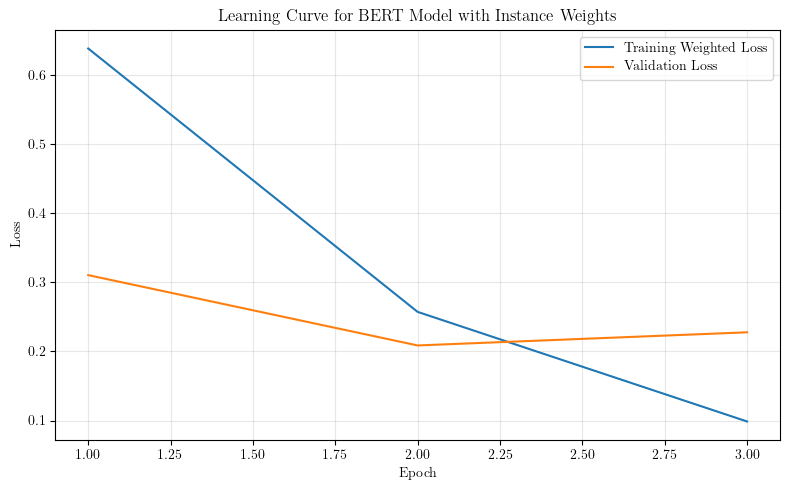

In [ ]:
# show the learning curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss_per_epoch) + 1), train_loss_per_epoch, label='Training Weighted Loss')
plt.plot(range(1, len(val_loss_per_epoch) + 1), val_loss_per_epoch, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Learning Curve for BERT Model with Instance Weights")
plt.tight_layout()
plt.savefig("assets/weighted_bert_learning_curve.png", transparent=True)
plt.show()

### Step 5: Evaluate the model


=== Classification Report (Partial Train) ===
              precision    recall  f1-score   support

    negative       0.83      1.00      0.91       336
     neutral       0.99      0.93      0.96      1717
    positive       0.90      0.95      0.93       709

    accuracy                           0.94      2762
   macro avg       0.91      0.96      0.93      2762
weighted avg       0.95      0.94      0.94      2762



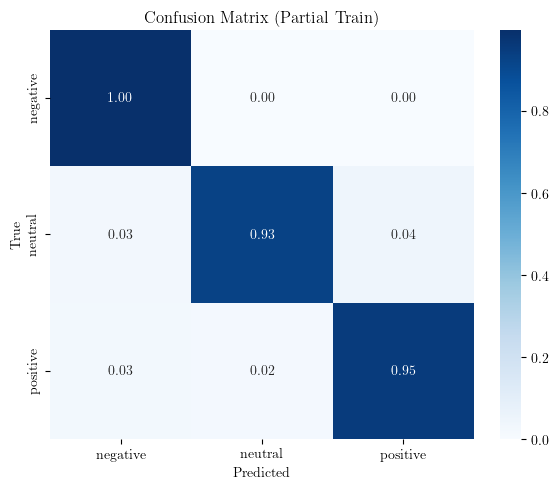


=== Classification Report (Test) ===
              precision    recall  f1-score   support

    negative       0.78      0.94      0.85        84
     neutral       0.97      0.93      0.95       429
    positive       0.88      0.89      0.89       178

    accuracy                           0.92       691
   macro avg       0.88      0.92      0.90       691
weighted avg       0.93      0.92      0.92       691



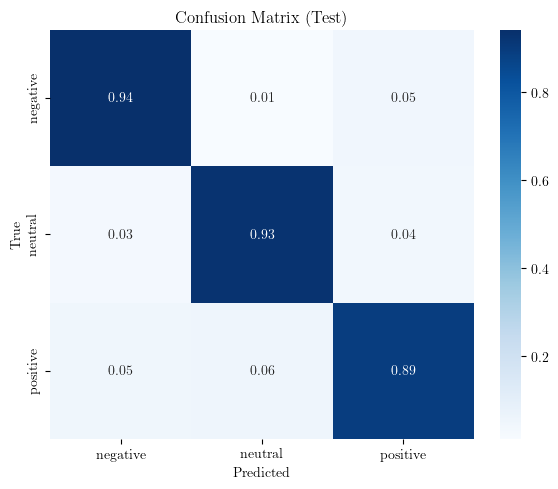

In [ ]:
def evaluate_dataset(dataset, split_name):
    model.eval()
    all_preds = []
    all_labels = []

    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"])
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    print(f"\n=== Classification Report ({split_name}) ===")
    print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))

    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({split_name})")
    plt.tight_layout()
    plt.savefig(f"assets/weighted_bert_confusion_matrix_{split_name}.png", transparent=True)
    plt.show()


semi_train_df = pd.read_csv('data/75Agree_train.csv')
semi_train_df["label"] = semi_train_df["label"].map(label2id)
semi_train_dataset = WeightlessTextDataset(semi_train_df, tokenizer)

df_test = pd.read_csv('data/75Agree_test.csv')
df_test["label"] = df_test["label"].map(label2id)
test_dataset = WeightlessTextDataset(df_test, tokenizer)

# evaluate the model on the training and test datasets
evaluate_dataset(semi_train_dataset, "Partial Train")
evaluate_dataset(test_dataset, "Test")